In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import keras
from keras import optimizers
from keras import backend as K
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten
from keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D 
from keras.utils import plot_model
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping

from tqdm import tqdm
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer 
import os, re, csv, math, codecs

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, recall_score

sns.set_style("whitegrid")
np.random.seed(0)


MAX_NB_WORDS = 100000
tokenizer = RegexpTokenizer(r'\w+')
stop_words = set(stopwords.words('english'))
stop_words.update(['.', ',', '"', "'", ':', ';', '(', ')', '[', ']', '{', '}'])

from subprocess import check_output
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
data = pd.read_csv("train.csv")

In [3]:
def clean_text(cmnt_text, clean_wiki_tokens = True):
    cmnt_text = cmnt_text.lower()
    #removing links
    cmnt_text = re.sub(r"https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{2,256}\.[a-z]{2,6}\b([-a-zA-Z0-9@:%_\+.~#?&//=]*)", "", cmnt_text)
    #removing IP addresses
    cmnt_text = re.sub(r"(25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)(\.(25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)){3}", "", cmnt_text)
    
    if clean_wiki_tokens:
        #removing images
        cmnt_text = re.sub(r"image:[a-zA-Z0-9]*\.jpg", " ", cmnt_text)
        cmnt_text = re.sub(r"image:[a-zA-Z0-9]*\.png", " ", cmnt_text)
        cmnt_text = re.sub(r"image:[a-zA-Z0-9]*\.gif", " ", cmnt_text)
        cmnt_text = re.sub(r"image:[a-zA-Z0-9]*\.bmp", " ", cmnt_text)
        
        #removing CSS
        cmnt_text = re.sub(r"#([A-Fa-f0-9]{6}|[A-Fa-f0-9]{3})", " ",cmnt_text)
        cmnt_text = re.sub(r"\{\|[^\}]*\|\}", " ", cmnt_text)
        
        #removing templates
        cmnt_text = re.sub(r"\[?\[user:.*\]", " ", cmnt_text)
        cmnt_text = re.sub(r"\[?\[wikipedia:.*\]", " ", cmnt_text)
        cmnt_text = re.sub(r"\[?\[special:.*\]", " ", cmnt_text)
        cmnt_text = re.sub(r"\[?\[category:.*\]", " ", cmnt_text)
        
    cmnt_text = re.sub(r"what's", "what is ", cmnt_text)
    cmnt_text = re.sub(r"\'s", " ", cmnt_text)
    cmnt_text = re.sub(r"\'ve", " have ", cmnt_text)
    cmnt_text = re.sub(r"can't", " cannot ", cmnt_text)
    cmnt_text = re.sub(r"n't", " not ", cmnt_text)
    cmnt_text = re.sub(r"i'm", " i am ", cmnt_text)
    cmnt_text = re.sub(r"\'m", " i am ", cmnt_text)
    cmnt_text = re.sub(r"\'re", " are ", cmnt_text)
    cmnt_text = re.sub(r"\'d", " would ", cmnt_text)
    cmnt_text = re.sub(r"\'ll", " will ", cmnt_text)
    cmnt_text = re.sub(r",", " ", cmnt_text)
    cmnt_text = re.sub(r"\.", " ", cmnt_text)
    cmnt_text = re.sub(r"!", " ! ", cmnt_text)
    cmnt_text = re.sub(r"\/", " ", cmnt_text)
    cmnt_text = re.sub(r"\?", " ? ", cmnt_text)
    cmnt_text = re.sub(r"\!", " ! ", cmnt_text)
    cmnt_text = re.sub(r"\"", " ", cmnt_text)
    cmnt_text = re.sub(r"\^", " ^ ", cmnt_text)
    cmnt_text = re.sub(r"\+", " + ", cmnt_text)
    cmnt_text = re.sub(r"\-", " - ", cmnt_text)
    cmnt_text = re.sub(r"\=", " = ", cmnt_text)
    cmnt_text = re.sub(r"'", " ", cmnt_text)
    cmnt_text = re.sub(r"(\d+)(k)", r"\g<1>000", cmnt_text)
    cmnt_text = re.sub(r":", " : ", cmnt_text)
    cmnt_text = re.sub(r" e g ", " eg ", cmnt_text)
    cmnt_text = re.sub(r" b g ", " bg ", cmnt_text)
    cmnt_text = re.sub(r" u s ", " american ", cmnt_text)
    cmnt_text = re.sub(r"\0s", "0", cmnt_text)
    cmnt_text = re.sub(r" 9 11 ", "911", cmnt_text)
    cmnt_text = re.sub(r"e - mail", "email", cmnt_text)
    cmnt_text = re.sub(r"j k", "jk", cmnt_text)
    cmnt_text = re.sub(r"\s{2,}", " ", cmnt_text)
    cmnt_text = re.sub(r"\n", " ", cmnt_text)
    
        
    return(cmnt_text)

In [4]:
data['comment_text'][123]

'Should say something about his views as an educationalist and socialist political commentator.\n\nLink to http://www.langandlit.ualberta.ca/Fall2004/SteigelBainbridge.html mentions this a bit - he stood as an election candidate for Respect.'

In [5]:
txt = clean_text(data['comment_text'][123])
print(txt)

should say something about his views as an educationalist and socialist political commentator link to mentions this a bit - he stood as an election candidate for respect 


In [6]:
data['clean_cmnts'] = data['comment_text'].apply(clean_text)

In [7]:
data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean_cmnts
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,explanation why the edits made under my userna...
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,d aww ! he matches this background colour i am...
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,hey man i am really not trying to edit war it ...
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,more i cannot make any real suggestions on im...
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,you sir are my hero any chance you remember wh...


In [8]:
data = data.drop(['comment_text'], axis=1)

In [9]:
data.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean_cmnts
0,0000997932d777bf,0,0,0,0,0,0,explanation why the edits made under my userna...
1,000103f0d9cfb60f,0,0,0,0,0,0,d aww ! he matches this background colour i am...
2,000113f07ec002fd,0,0,0,0,0,0,hey man i am really not trying to edit war it ...
3,0001b41b1c6bb37e,0,0,0,0,0,0,more i cannot make any real suggestions on im...
4,0001d958c54c6e35,0,0,0,0,0,0,you sir are my hero any chance you remember wh...


In [10]:
#load embeddings
print('loading word embeddings...')
embeddings_index = {}
f = codecs.open('wiki.simple.vec', encoding='utf-8')
for line in tqdm(f):
    values = line.rstrip().rsplit(' ')
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('found %s word vectors' % len(embeddings_index))

204it [00:00, 2037.59it/s]

loading word embeddings...


111052it [00:14, 7921.18it/s]

found 111052 word vectors


num train:  159571


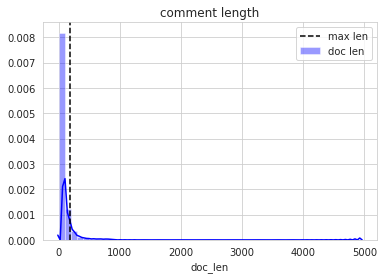

180


In [11]:
print("num train: ", data.shape[0])

label_names = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

#visualize word distribution
data['doc_len'] = data['clean_cmnts'].apply(lambda words: len(words.split(" ")))
max_seq_len = np.round(data['doc_len'].mean() + data['doc_len'].std()).astype(int)
sns.distplot(data['doc_len'], hist=True, kde=True, color='b', label='doc len')
plt.axvline(x=max_seq_len, color='k', linestyle='--', label='max len')
plt.title('comment length'); plt.legend()
plt.show()
print(max_seq_len)

In [12]:
data.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean_cmnts,doc_len
0,0000997932d777bf,0,0,0,0,0,0,explanation why the edits made under my userna...,48
1,000103f0d9cfb60f,0,0,0,0,0,0,d aww ! he matches this background colour i am...,22
2,000113f07ec002fd,0,0,0,0,0,0,hey man i am really not trying to edit war it ...,44
3,0001b41b1c6bb37e,0,0,0,0,0,0,more i cannot make any real suggestions on im...,118
4,0001d958c54c6e35,0,0,0,0,0,0,you sir are my hero any chance you remember wh...,15


In [13]:
X = data[['clean_cmnts']]
y = data[label_names].values

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [15]:
raw_docs_train = X_train['clean_cmnts'].tolist()
raw_docs_test = X_test['clean_cmnts'].tolist() 
num_classes = len(label_names)

print("pre-processing train data...")
processed_docs_train = []
for doc in tqdm(raw_docs_train):
    tokens = tokenizer.tokenize(doc)
    filtered = [word for word in tokens if word not in stop_words]
    processed_docs_train.append(" ".join(filtered))
#end for

#print("pre-processing test data...")
processed_docs_test = []
for doc in tqdm(raw_docs_test):
    tokens = tokenizer.tokenize(doc)
    filtered = [word for word in tokens if word not in stop_words]
    processed_docs_test.append(" ".join(filtered))
#end for

print("tokenizing input data...")
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, lower=True, char_level=False)
tokenizer.fit_on_texts(processed_docs_train + processed_docs_test)  #leaky
word_seq_train = tokenizer.texts_to_sequences(processed_docs_train)
word_seq_test = tokenizer.texts_to_sequences(processed_docs_test)
word_index = tokenizer.word_index
print("dictionary size: ", len(word_index))

#pad sequences
word_seq_train = sequence.pad_sequences(word_seq_train, maxlen=max_seq_len)
word_seq_test = sequence.pad_sequences(word_seq_test, maxlen=max_seq_len)

  1%|          | 1387/111699 [00:00<00:07, 13840.41it/s]

pre-processing train data...


100%|██████████| 47872/47872 [00:01<00:00, 28569.66it/s]


tokenizing input data...
dictionary size:  179247


In [16]:
#training params
batch_size = 256 
num_epochs = 8 

#model parameters
num_filters = 64 
embed_dim = 300 
weight_decay = 1e-4

In [17]:
#embedding matrix
print('preparing embedding matrix...')
words_not_found = []
nb_words = min(MAX_NB_WORDS, len(word_index))
embedding_matrix = np.zeros((nb_words, embed_dim))
for word, i in word_index.items():
    if i >= nb_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
    else:
        words_not_found.append(word)
print('number of null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

preparing embedding matrix...
number of null word embeddings: 50556


In [18]:
#CNN architecture
print("training CNN ...")
model = Sequential()
model.add(Embedding(nb_words, embed_dim,
          weights=[embedding_matrix], input_length=max_seq_len, trainable=False))
model.add(Conv1D(num_filters, 7, activation='relu', padding='same'))
model.add(MaxPooling1D(2))
model.add(Conv1D(num_filters, 7, activation='relu', padding='same'))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Dense(num_classes, activation='sigmoid'))  #multi-label (k-hot encoding)

adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
model.summary()

training CNN ...
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 180, 300)          30000000  
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 180, 64)           134464    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 90, 64)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 90, 64)            28736     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 64)                0         
_________________________________________________________________
drop

In [19]:
#define callbacks
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=4, verbose=1)
callbacks_list = [early_stopping]

In [20]:
#model training
hist = model.fit(word_seq_train, y_train, batch_size=batch_size, 
                 epochs=num_epochs, callbacks=callbacks_list, 
                 validation_split=0.1, shuffle=True, verbose=1)

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 100529 samples, validate on 11170 samples
Epoch 1/8
100529/100529 [==============================] - 328s 3ms/step - loss: 0.1070 - acc: 0.9665 - val_loss: 0.0712 - val_acc: 0.9763
Epoch 2/8
100529/100529 [==============================] - 336s 3ms/step - loss: 0.0674 - acc: 0.9786 - val_loss: 0.0656 - val_acc: 0.9775
Epoch 3/8
100529/100529 [==============================] - 349s 3ms/step - loss: 0.0601 - acc: 0.9802 - val_loss: 0.0640 - val_acc: 0.9782
Epoch 4/8
100529/100529 [==============================] - 336s 3ms/step - loss: 0.0549 - acc: 0.9814 - val_loss: 0.0631 - val_acc: 0.9785
Epoch 5/8
100529/100529 [==============================] - 336s 3ms/step - loss: 0.0504 - acc: 0.9825 - val_loss: 0.0632 - val_acc: 0.9779
Epoch 00005: early stopping


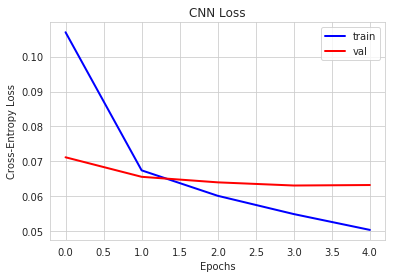

In [40]:
#generate plots
plt.figure()
plt.plot(hist.history['loss'], lw=2.0, color='b', label='train')
plt.plot(hist.history['val_loss'], lw=2.0, color='r', label='val')
plt.title('CNN Loss')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy Loss')
plt.legend(loc='upper right')
plt.savefig('CNN_Loss.png', bbox_inches='tight')
plt.show()

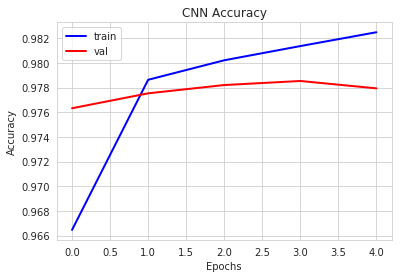

In [39]:
plt.figure()
plt.plot(hist.history['acc'], lw=2.0, color='b', label='train')
plt.plot(hist.history['val_acc'], lw=2.0, color='r', label='val')
plt.title('CNN Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.savefig('CNN_Accuracy.png', bbox_inches='tight')
plt.show()

In [23]:
y_pred = model.predict(word_seq_test)

In [24]:
y_pred

array([[1.6714400e-01, 1.0523498e-03, 3.6810458e-02, 1.9738674e-03,
        6.3367516e-02, 1.1613637e-02],
       [6.2766671e-04, 1.4901161e-07, 8.3178282e-05, 1.1920929e-07,
        1.0457635e-04, 4.3809414e-06],
       [5.1612347e-02, 1.2993813e-05, 4.1614771e-03, 2.8312206e-05,
        7.9929531e-03, 3.5744905e-04],
       ...,
       [3.1857014e-01, 1.3180941e-02, 9.8525047e-02, 1.9619912e-02,
        1.5211338e-01, 4.6565413e-02],
       [2.4167597e-03, 7.7486038e-07, 3.3381581e-04, 1.6093254e-06,
        4.6730042e-04, 2.6434660e-05],
       [2.8337538e-03, 8.6426735e-07, 5.2341819e-04, 6.5565109e-07,
        6.3961744e-04, 2.6315451e-05]], dtype=float32)

In [25]:
p = y_pred.round()

In [27]:
for i, j in enumerate(label_names):
    print(j)
    print(confusion_matrix(y_test[:, i], p[:, i]))
    print("f1_score: ",f1_score(y_test[:, i], p[:, i]))
    print("Accuracy: ",accuracy_score(y_test[:, i], p[:, i]))
    print("recall_score: ",recall_score(y_test[:, i], p[:, i]))
    print('\n')

toxic
[[42421   869]
 [ 1319  3263]]
f1_score:  0.7489098003213219
Accuracy:  0.9542947860962567
recall_score:  0.7121344391095591


severe_toxic
[[47304    82]
 [  371   115]]
f1_score:  0.3367496339677892
Accuracy:  0.9905372660427807
recall_score:  0.2366255144032922


obscene
[[44775   541]
 [  569  1987]]
f1_score:  0.7816679779701022
Accuracy:  0.9768131684491979
recall_score:  0.7773865414710485


threat
[[47736     0]
 [  136     0]]
f1_score:  0.0
Accuracy:  0.9971590909090909
recall_score:  0.0


insult
[[44666   817]
 [  679  1710]]
f1_score:  0.6956875508543531
Accuracy:  0.96875
recall_score:  0.7157806613645877


identity_hate
[[47440     0]
 [  432     0]]
f1_score:  0.0
Accuracy:  0.990975935828877
recall_score:  0.0




In [29]:
# Creating empty prediction array
col = ['toxic', 'severe_toxic', 'obscene', 'threat','insult', 'identity_hate']

# Predict on train, val and test datasets
pred_train = model.predict(word_seq_train)
pred_test = model.predict(word_seq_test)
#pred_val = model.predict(X_val)

# Emply array to collect AUC scores
AUC = np.zeros((2,6))
AUC

array([[0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.]])

In [35]:
from sklearn import metrics
for i,x in enumerate(col):
    auc = np.array([metrics.roc_auc_score(y_train[:,i], pred_train[:,i]),
                    metrics.roc_auc_score(y_test[:,i], pred_test[:,i])])
    print(x,"Train AUC:",auc[0],", Test AUC:",auc[1])
    AUC[:,i] = auc
    
avg_auc = AUC.mean(axis=1)
print("Average Train AUC:",avg_auc[0],", Average Test AUC:",avg_auc[1])

toxic Train AUC: 0.982418041029882 , Test AUC: 0.9589982429463006
severe_toxic Train AUC: 0.9914167155410634 , Test AUC: 0.9825831942514318
obscene Train AUC: 0.9914464550653026 , Test AUC: 0.9787199168668607
threat Train AUC: 0.9743867347874942 , Test AUC: 0.9513041704866965
insult Train AUC: 0.9854706572727103 , Test AUC: 0.9703491579110322
identity_hate Train AUC: 0.9790215930553015 , Test AUC: 0.9564829209215538
Average Train AUC: 0.9840266994586256 , Average Test AUC: 0.9664062672306458


In [32]:
y_test

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [37]:
for i, j in enumerate(label_names):
    print(j)
    print(confusion_matrix(y_train[:, i], pred_train[:, i].round()))
    print("f1_score: ",f1_score(y_train[:, i], pred_train[:, i].round()))
    print("Accuracy: ",accuracy_score(y_train[:, i], pred_train[:, i].round()))
    print("recall_score: ",recall_score(y_train[:, i], pred_train[:, i].round()))
    print('\n')

toxic
[[99772  1215]
 [ 2183  8529]]
f1_score:  0.8338873680093859
Accuracy:  0.9695789577346261
recall_score:  0.796209858103062


severe_toxic
[[110400    190]
 [   820    289]]
f1_score:  0.36397984886649876
Accuracy:  0.9909578420576729
recall_score:  0.260595130748422


obscene
[[104678   1128]
 [   860   5033]]
f1_score:  0.835075493612079
Accuracy:  0.9822021683273798
recall_score:  0.8540641438995419


threat
[[111357      0]
 [   342      0]]
f1_score:  0.0
Accuracy:  0.9969381999838852
recall_score:  0.0


insult
[[104351   1860]
 [  1160   4328]]
f1_score:  0.7413497773210003
Accuracy:  0.9729630524892793
recall_score:  0.7886297376093294


identity_hate
[[110726      0]
 [   973      0]]
f1_score:  0.0
Accuracy:  0.9912890894278373
recall_score:  0.0


